# Chapter 6 - Example: Ocean Data 
###  Ocean area above a given temperature threshold

In this chapter we exemplify the use of Sea Surface Temperature (SST) data in the cloud. This example analyze a time sereis from an area of the ocean or a point. If an area, averages SST values. 

Then it analyze if when SST is above a given threshold. This could be used to study marine heatwaves, or use a threshold relevant for a marine species of interest.

In [1]:
# Import libraries
import warnings # this library helps to make your code execution less messy
warnings.simplefilter('ignore') # filter some warning messages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import hvplot.pandas # this library helps to make interactive plots
import hvplot.xarray
import fsspec # these libraries help reading cloud data
import s3fs
import dask
from dask.distributed import performance_report, Client, progress

In [2]:
# Input parameters
latr = [19, 20] # make sure lat1 > lat2 since no test is done below to simplify the code
lonr = [-158, -157] # lon1 > lon2
# time frame
dater = ['2012-01-01','2019-12-31'] # dates on the format 'YYYY-MM-DD' as string

***
## We are going to use the Multi-Scale Ultra High Resolution (MUR) Sea Surface Temperature (SST) data set
### from the Amazon (AWS) Cloud
### For more info and links to the data see: https://registry.opendata.aws/mur/

This dataset is stored in 'zarr' format, which is optimized for the cloud and large datasets. It is not stored one 'image' at at time, but in 'chunks', so it is perfect for extracting time series.

First, we open the dataset and explore it, but we are not acquiring it yet

In [3]:
# one method
# file_location = 's3://mur-sst/zarr-v1'
# ds_sst = xr.open_zarr(fsspec.get_mapper(file_location, anon=True),consolidated=True)

# another, which has updated and optimized data
file_location = 'https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1'
ds_sst = xr.open_zarr(file_location,consolidated=True)

# look at the datarray structure, description and attributes
ds_sst
# click on the page icon on the far right of each varraible/coordinate for information

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 6443)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(5, 1799, 3600), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_name:               JPL MUR SST project
    creator_url:                http://mur.jpl.nasa.gov
    date_created:               20200124T010755Z
    easternmost_longitude:      180.0
    file_quality_level:         3
    gds_version_id:             2.0
    geospatial_lat_resolution:  0.009999999776482582
    geospatial_lat_units:       degrees north
    geospatial_lon_resolution:  0.009999999776482582
    geospatial_lon_units:       degrees east
    history:                    created at nominal 4-day latency; replaced nr...
    id:                         MUR-JPL-L4-GLOB-v04.1
    institution:                Jet Propulsion Laboratory
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    license:                    These data are available free of charge under...
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    naming_authority:           org.ghrsst
    netcdf_version_id:          4.1
    northernmost_latitude:      90.0
    platform:                   Terra, Aqua, GCOM-W, MetOp-A, MetOp-B, Buoys/...
    processing_level:           L4
    product_version:            04.1
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_email:            ghrsst-po@nceo.ac.uk
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    sensor:                     MODIS, AMSR2, AVHRR, in-situ
    source:                     MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRM...
    southernmost_latitude:      -90.0
    spatial_resolution:         0.01 degrees
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    start_time:                 20200116T090000Z
    stop_time:                  20200116T090000Z
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

## Now we load only the data we want 

In [4]:
# if we give it only one point. selects and load onlyy that point for the data range given.
if (latr[0]==latr[1]) | (lonr[0]==lonr[1]):
    sst = ds_sst['analysed_sst'].sel(time = slice(dater[0],dater[1]),
                                            lat  = latr[0], 
                                            lon  = lonr[0]
                                           ).load()
else: # if we give it an area, it extract the area and average SST over the area and returns a time series of SST
    sst = ds_sst['analysed_sst'].sel(time = slice(dater[0],dater[1]),
                                            lat  = slice(latr[0], latr[1]), 
                                            lon  = slice(lonr[0], lonr[1])
                                           ).mean(dim={'lat','lon'}, skipna=True, keep_attrs=True).load() # skip 'not a number' values and keep attributes

sst = sst-273.15 # transform into degrees Celsius
sst.to_netcdf('sst_example.nc') # we are saving the data. if we need to come back to analyze the same data, we do not have to acquire it again.
sst

<xarray.DataArray 'analysed_sst' (time: 2922)>
array([24.643799, 24.584167, 24.53534 , ..., 26.155853, 26.120667,
       26.101807], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01T09:00:00 ... 2019-12-31T09:00:00

***
## Excute next cell if reading the data from a file - either no access to cloud, or not want to keep reading. Skip otherwise

In [5]:
# in the meantime....
sst = xr.open_dataset('./sst_example.nc') # read a netcdf
sst.close()
sst = sst.analysed_sst

***
## Let's plot the data, with two different libraries.
#### 1. matplotlib, that we already learn. static nice figures.
#### 2. hovplot, a more interactive library for web display, that will provide you with the data details when you hover your cursor over the line in the figure. 

matplotlib


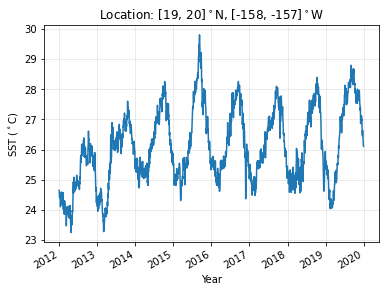

hovplot


:Curve   [Date]   (SST (C))

In [6]:
# matplotlib #
print('matplotlib') 
sst.plot() # this is all you need

# all the stuff here to make it look better. try commenting them out
plt.ylabel('SST ($^\circ$C)')
plt.xlabel('Year')
plt.title('Location: '+str(latr)+'$^\circ$N, '+str(lonr)+'$^\circ$W')
plt.grid(True, alpha=0.3)
plt.show()

# hovplot #
print('hovplot')
df = pd.DataFrame(data=sst.data, index=sst.time.data,columns=['SST (C)'])
df.index.name = 'Date'
df.hvplot(grid=True)

***
## Now let's analyze our data.
#### First, the classic climatology and anomalies. Just to use our new hovplot tool.

In [7]:
# Calculate the climatology
sst_climatology = sst.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False) # group by day, all years. skipna ignore miissing values (NaN=Not a Number)
sst_climstd = sst.groupby('time.dayofyear').std('time',keep_attrs=True,skipna=False) # calculate standard deviation. keep attributes.

# creates a pandas dataframe, a table , to plot easily using hvplot.
df = pd.DataFrame(data=sst_climatology.data, index=sst_climatology.dayofyear.data,columns=['SST (C)'])
df['+Std']=sst_climstd.data+sst_climatology.data 
df['-Std']=-sst_climstd.data+sst_climatology.data
df.index.name = 'Day of Year'
df.hvplot(color=['k','grey','grey'], grid=True, title='SST Climatology') # plot the climatology (black, and the standard deviation in grey)

:NdOverlay   [Variable]
   :Curve   [Day of Year]   (value)

In [8]:
# Calculate the anomalies
sst_anomaly = sst.groupby('time.dayofyear')-sst_climatology 
sst_anomaly_monthly = sst_anomaly.resample(time='1MS', loffset='15D').mean(keep_attrs=True,skipna=False)

# again, making a pandas dataframe for easy plotting with hvplot
df2 = pd.DataFrame(data=sst_anomaly.data, index=sst.time.data,columns=['SSTa (C)'])
df2.index.name = 'Date'
df2.hvplot.area(x='Date', y='SSTa (C)', grid=True, title='SST Anomalies')

:Area   [Date]   (SSTa (C))

***
## Now, let's use the plots above to analyze the data further. Let's choose our threshold.

### One way is to set a threshold that has some relevance.  For example, a thermal threshold for a marine species we are studying. 

### Another way is choosing the max value in the climatology (mean climatology + 1 standard deviation), which we can calculate or find out by hovering our cursor over the climatology plot above.

## Once the threshold is choosen, we will identify days with SST over that threshold in our time series, and count how many times that occurred per year

Max climatological SST =  28.8 C


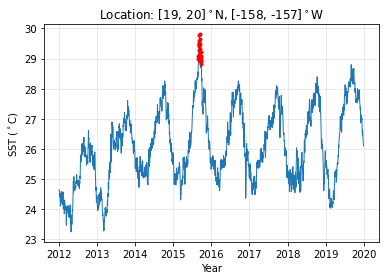

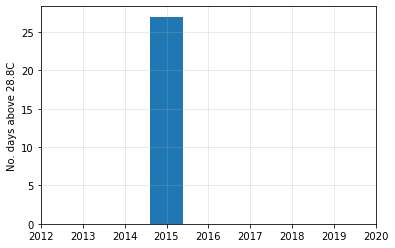




Biologically relevant SST =  28 C


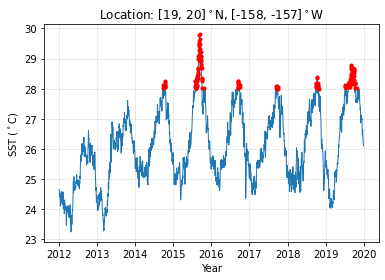

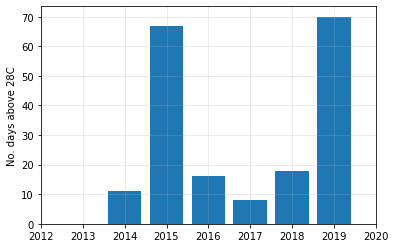

In [9]:
# first define a function that take the threshold and analyze and plot our data
def SST_above(thr):
    # plotting data, highlighting values above threshold
    plt.plot(sst.time,sst.data, lw=1)
    a=sst>=thr
    plt.plot(sst.time[a], sst.data[a],'.r')
    # all stuff here to make it look good
    plt.ylabel('SST ($^\circ$C)')
    plt.xlabel('Year')
    plt.title('Location: '+str(latr)+'$^\circ$N, '+str(lonr)+'$^\circ$W')
    plt.grid(True, alpha=0.3)
    plt.show()

    # plotting data, # values above threshold per year
    dts = sst[sst>=thr].time
    hot_days = dts.groupby('time.year').count()
    plt.bar(hot_days.year, hot_days)
    plt.xlim(int(dater[0][:4]), int(dater[1][:4])+1)
    plt.ylabel('No. days above '+str(np.round(thr,1))+'C')
    plt.grid(True, alpha=0.3)
    plt.show()

##### two examples
# maximum climatology threshold
thr = df['+Std'].max() # setting threshold as maximum climatological value: mean + 1 standard deviation
print('Max climatological SST = ',np.round(thr,1),'C')
SST_above(thr) # Call function

### next example
# set a relevant threshold. For example, for hawaii, 28C is a relevant threshold for coral bleaching (https://coralreefwatch.noaa.gov/product/5km/tutorial/crw08a_bleaching_threshold.php)
thr = 28
print('\n\n')
print('Biologically relevant SST = ',thr,'C')
SST_above(thr)

***
### Now let's try a different definition of anomalously warm SST days. 
## Marine heatwaves
### They are defined as any period with SST anomalies above a threshold defined as the 90th percentile value of the SST anomalies for a defined period - in this case our data time period.

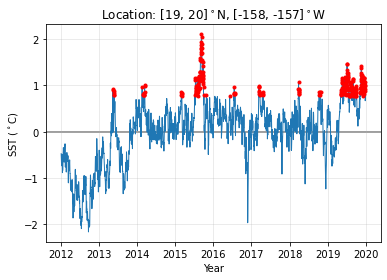

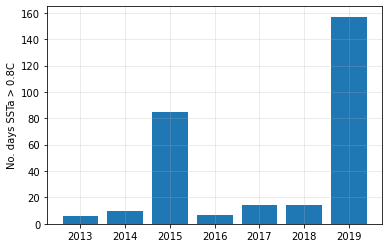

<xarray.DataArray 'time' (year: 7)>
array([  6,  10,  85,   7,  14,  14, 157])
Coordinates:
  * year     (year) int64 2013 2014 2015 2016 2017 2018 2019

In [10]:
# calculate the threshold: 90th percentile
thr = np.percentile(sst_anomaly, 90)

# same plot as in our function above, but this time we are plotting the anomalies.
plt.plot(sst_anomaly.time,sst_anomaly.data, lw=1)
plt.axhline(y=0, c='k', zorder=0, alpha=0.5)

a=sst_anomaly>=thr
plt.plot(sst_anomaly.time[a], sst_anomaly.data[a],'.r')
# all stuff here to make it look good
plt.ylabel('SST ($^\circ$C)')
plt.xlabel('Year')
plt.title('Location: '+str(latr)+'$^\circ$N, '+str(lonr)+'$^\circ$W')
plt.grid(True, alpha=0.3)
plt.show()

# how many days we have values above that threshoold per year
dts = sst_anomaly[sst_anomaly>=thr].time
mhw = dts.groupby('time.year').count()
plt.bar(mhw.year,mhw)
plt.ylabel('No. days SSTa > '+str(np.round(thr,1))+'C')
plt.grid(True, alpha=0.3)
plt.show()
mhw # print the numbers

## Finally, let's see how the SST field around this point or the region selected look for a hottest day and our coldest day.

In [11]:
minv = sst.min() # find mininum SST value
mindate = sst[sst==minv].time.data # find when this min value occurred
maxv = sst.max() # find maximum SST value
maxdate = sst[sst==maxv].time.data # find when the max value occurred

In [12]:
def select_area(day): # function going back to the SST data in the cloud, we now load a different subset, given 
    if (latr[0]==latr[1]) | (lonr[0]==lonr[1]): # if input data was one point
        sst2 = ds_sst.sel(time = day,
                            lat  = slice(latr-2,latr+2),
                            lon  = slice(lonr-2,lonr+2)
                            ).load()
    else: # if input data was a region
        sst2 = ds_sst.sel(time = day,
                            lat  = slice(latr[0], latr[1]), 
                            lon  = slice(lonr[0], lonr[1])
                            ).load()
    sst3 = sst2['analysed_sst']-273.15
    mask = sst2['mask'].where(sst2['mask']<2)
    sst3 = sst3*mask
    return sst3

In [25]:
# plot warmest day
msst = select_area(maxdate)
msst.hvplot.quadmesh(x='lon',y='lat',coastline=True, clabel='T [C]', cmap='coolwarm', title=str(maxdate[0])[:10])


:DynamicMap   [time]
   :Overlay
      .QuadMesh.I  :QuadMesh   [lon,lat]   (value)
      .Coastline.I :Feature   [Longitude,Latitude]

In [26]:
# plot coolest day
msst = select_area(mindate)
msst.hvplot.quadmesh(x='lon',y='lat',coastline=True, clabel='T [C]', cmap='coolwarm', title=str(mindate[0])[:10])

:DynamicMap   [time]
   :Overlay
      .QuadMesh.I  :QuadMesh   [lon,lat]   (value)
      .Coastline.I :Feature   [Longitude,Latitude]

***
# Resources

[Pangeo OSM2020 Tutorial](https://github.com/pangeo-gallery/osm2020tutorial). This is a very good tutorial for ocean application and cloud computing. Plentyy of examples. Many of the commands here are from this tutorial.

[MUR SST Data](https://registry.opendata.aws/mur/). SST data in the cloud, with references the official datta website, examplles and other resources.

[hvplot site](https://hvplot.holoviz.org/index.html). Plotting tool used here.

[Marine heatwaves](http://www.marineheatwaves.org/all-about-mhws.html). A good place to begin to get info about the subject.

[Marine heatwaves code](https://github.com/ecjoliver/marineHeatWaves). Marine heatwaves code from E. Oliver. 